# Static Nonlinear

Presentation of the neural model supported by kernel regression on static nonlinear dataset.

*Note*: to see how dataset was generated, go to `dataset.ipynb`.

In [1]:
import sys

sys.path.append("..")  # we run from subdirectory, so to access sources append repo root to path

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from pydentification.data.datamodules.simulation import SimulationDataModule
from pydentification.models.modules.feedforward import TimeSeriesLinear
from sklearn import metrics

from src.nonparametric import kernels
from src.nonparametric.memory import ExactMemoryManager
from src.training.module import BoundedSimulationTrainingModule
from src.training.utils import unbatch

In [3]:
sns.set()

# Settings

Settings for the experiment, including paths, dataset size etc.

In [4]:
data_path = r"../data/csv/sine-function.csv"
plot_path = r"../data/plots/sine-function/"
model_path = r"../models/sine-function-network-parameters.pt"

test_size = 1000

In [5]:
dataset = pd.read_csv(data_path)

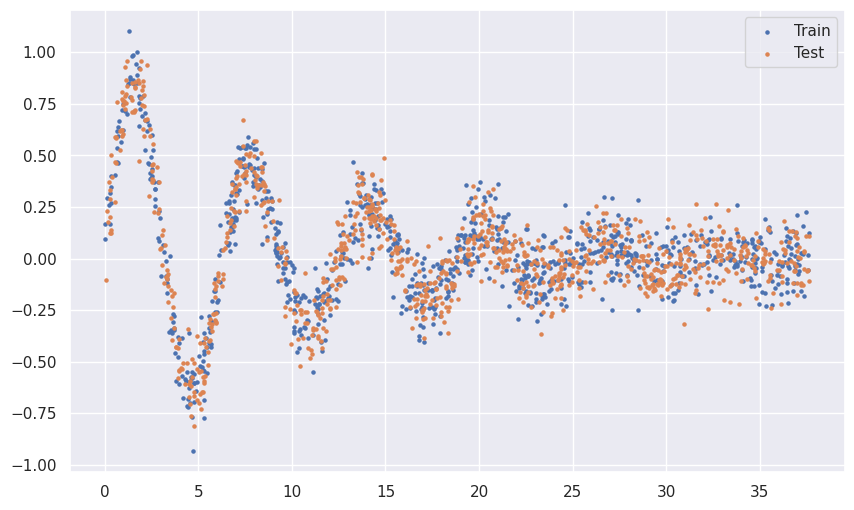

In [6]:
_ = plt.figure(figsize=[10, 6])

train_size = len(dataset) - test_size
_ = plt.scatter(dataset["x"].iloc[:train_size], dataset["y"].iloc[:train_size], s=5)
_ = plt.scatter(dataset["x"].iloc[train_size:], dataset["y"].iloc[train_size:], s=5)

_ = plt.legend(["Train", "Test"])
_ = plt.savefig(rf"{plot_path}/dataset.png")

### Dataset

In [7]:
dm = SimulationDataModule.from_csv(
    dataset_path=data_path,
    input_columns=["x"],
    output_columns=["y"],
    test_size=test_size,
    batch_size=32,  # used for prediction, we will not train network here
    validation_size=0.0,  # no need for validation
    shift=1,
    forward_input_window_size=1,
    forward_output_window_size=1,
    forward_output_mask=0,
)

In [8]:
# setup the data for prediction
dm.setup("fit")
dm.setup("predict")

In [9]:
for x, y in dm.train_dataloader():
    print(x.shape, y.shape)
    break  # make sure shapes are as we expect

torch.Size([32, 1, 1]) torch.Size([32, 1, 1])


In [10]:
for x, y in dm.test_dataloader():
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 1]) torch.Size([32, 1, 1])


# Model

Create the model from neural network we have trained before.

The settings for kernel regression are selected using hyper-parameter search, which are the best we found for this problem.

In [11]:
network = torch.nn.Sequential(
    TimeSeriesLinear(n_input_time_steps=1, n_input_state_variables=1, n_output_time_steps=4, n_output_state_variables=16),
    torch.nn.Tanh(),
    TimeSeriesLinear(n_input_time_steps=4, n_input_state_variables=16, n_output_time_steps=4, n_output_state_variables=16),
    torch.nn.Tanh(),
    TimeSeriesLinear(n_input_time_steps=4, n_input_state_variables=16, n_output_time_steps=4, n_output_state_variables=16),
    torch.nn.Tanh(),
    TimeSeriesLinear(n_input_time_steps=4, n_input_state_variables=16, n_output_time_steps=4, n_output_state_variables=16),
    torch.nn.Tanh(),
    TimeSeriesLinear(n_input_time_steps=4, n_input_state_variables=16, n_output_time_steps=4, n_output_state_variables=16),
    torch.nn.Tanh(),
    TimeSeriesLinear(n_input_time_steps=4, n_input_state_variables=16, n_output_time_steps=1, n_output_state_variables=1),
)

In [12]:
network.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [13]:
model = BoundedSimulationTrainingModule(
    network=network,
    optimizer=torch.optim.Adam(network.parameters()),  # will not be used anyway
    lr_scheduler=None,
    bound_during_training=False,
    bound_crossing_penalty=0.0,
    bandwidth=0.2,
    kernel=kernels.box_kernel,
    memory_manager=ExactMemoryManager(),  # dataset is low-dimensional, so no need to use approximated nearest neighbours here
    lipschitz_constant=1,  # known
    delta=0.1,  # user defined
    noise_variance=0.05,  # we know the variance from dataset generation
    k_neighbours=10,
    power=2,
    radius=None,
    memory_device="cpu",
    predict_device="cpu",
)

In [14]:
# unbatch the dataset to prepare memory manager
x, y = unbatch(dm.train_dataloader())
x.shape, y.shape

(torch.Size([1000, 1, 1]), torch.Size([1000, 1, 1]))

In [15]:
model.prepare(x, y)

# Test

Run the predictions with trained network and kernel regression.

In [16]:
outputs = model.predict_dataloader(dm.test_dataloader())

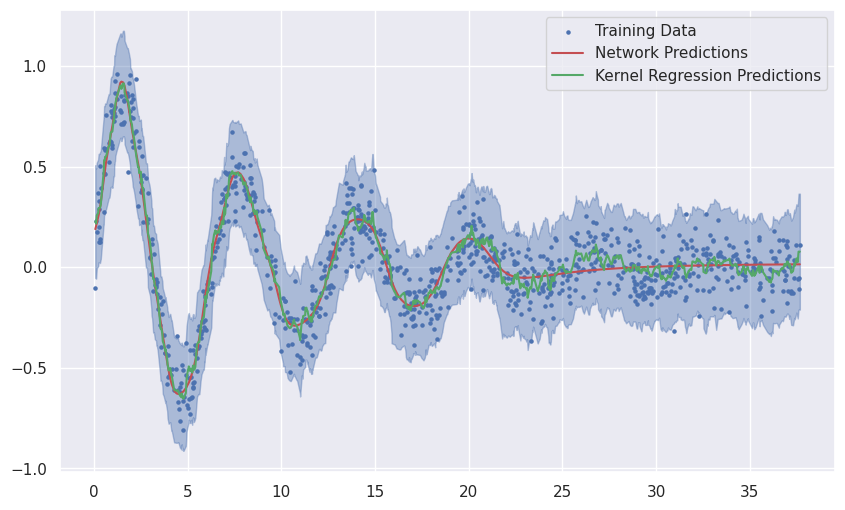

In [17]:
_ = plt.figure(figsize=[10, 6])

index = np.argsort(dataset["x"].iloc[train_size:].values)  # sort index from smallest to largest to plot predictions with line
x = (dataset["x"].iloc[train_size:].values[index])  # indenedent variable

_ = plt.scatter(x, dataset["y"].iloc[train_size:].values[index], s=5)
_ = plt.plot(x, outputs["network_predictions"].numpy().flatten()[index], c="r")
_ = plt.plot(x, outputs["nonparametric_predictions"][index], c="g")
_ = plt.fill_between(x, outputs["lower_bound"].numpy().flatten()[index], outputs["upper_bound"].numpy().flatten()[index], color="b", alpha=0.4)

_ = plt.legend(["Training Data", "Network Predictions", "Kernel Regression Predictions"])
_ = plt.savefig(fr"{plot_path}/predictions.png")

# Metrics

Compute metrics to report in the paper.

In [18]:
def range_ratio_error(error, y_true):
    return error / (y_true.max() - y_true.min())

def report(predictions, targets):
    rmse_network = metrics.root_mean_squared_error(y_true=targets, y_pred=predictions["network_predictions"].numpy().flatten())
    rmse_nonparametric = metrics.root_mean_squared_error(y_true=targets, y_pred=predictions["nonparametric_predictions"].numpy().flatten())
    rmse_bound = metrics.root_mean_squared_error(y_true=targets, y_pred=predictions["lower_bound"].numpy().flatten())

    print(f"RMSE NET:    {rmse_network:.4f}")
    print(f"RMSE KRE:    {rmse_nonparametric:.4f}")
    print(f"RMSE BOUNDS: {rmse_bound:.4f}", end="\n\n")
    print(f"RRR NET:     {range_ratio_error(error=rmse_network, y_true=targets):.2%}")
    print(f"RRR KRE:     {range_ratio_error(error=rmse_nonparametric, y_true=targets):.2%}")
    print(f"RRR BOUNDS:  {range_ratio_error(error=rmse_bound, y_true=targets):.2%}")

In [19]:
report(outputs, dataset["y"].iloc[train_size:].values)

RMSE NET:    0.1037
RMSE KRE:    0.1042
RMSE BOUNDS: 0.2771

RRR NET:     5.86%
RRR KRE:     5.89%
RRR BOUNDS:  15.67%
